# Finding hyperbolic Trajectory
----
We take as input the model paramters, forcing type and parameters, time interval and number of points along the time interval we would like to evaluate the hyperbolic trajectories at.

In [1]:

import numpy as np
from numpy import cos, sin, cosh, sinh, tanh, array,pi, exp,array,sqrt
from numpy.linalg import norm,solve
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.linalg
import scipy.io
from model import linearisedSystem,model,eigen,Usolve,Lsolve

We find the hyperbolic trajectories by solving a BVP. The initial guess chosen depends upon the type of forcing applied by solving the linearised system

In [2]:
def linearHyperbolicCosine(Amp,w,Pplus,Pminus,Pplusinv,Pinvminus,lambda2, omega, lambda3, lambda4):   # Finds the analytical solution for the displacement of the hyperbolic trajectory from the saddle point
    # for the linearised system. Will be used as the intial guess.
    # This function provides this in the case G(t) = Amp*cos(w*t)
    #Pplus,Pminus is the change of basis matrix from the eigenbasis to the standard coordinates.
    A1plus = Amp*Pplusinv.dot(array([0,0,0,1]))[0]
    A2plus = Amp*Pplusinv.dot(array([0,0,0,1]))[1]
    A3plus = Amp*Pplusinv.dot(array([0,0,0,1]))[2]
    A4plus = Amp*Pplusinv.dot(array([0,0,0,1]))[3]
    #need to replace k here with a lambda2
    psi1 = lambda t: .25*((-2*lambda2)*cos((w+omega)*t)+2*(w+omega)*sin((w+omega)*t)  )/(lambda2**2 + (omega + w)**2)  +         .25*( -2*lambda2*cos((omega-w)*t) + 2*(omega-w)*sin((omega-w)*t)  )/(lambda2**2 +(omega-w)**2)
    psi2 = lambda t: .25*((-2*lambda2)*sin((w+omega)*t) - 2*(w+omega)*cos((w+omega)*t)  )/(lambda2**2 + (omega + w)**2)    +         .25*(-2*lambda2*sin((omega-w)*t) - 2*(omega-w)*cos((omega-w)*t)  )/(lambda2**2 + (omega - w)**2) 
    XQplus = lambda t : Pplus.dot(array([A1plus*cos(omega*t)*psi1(t) + A2plus*cos(omega*t)*psi2(t) + A1plus*sin(omega*t)*psi2(t) - A2plus*sin(omega*t)*psi1(t),
                                A1plus*sin(omega*t)*psi1(t) + A2plus*sin(omega*t)*psi2(t) - A1plus*cos(omega*t)*psi2(t) + A2plus*cos(omega*t)*psi1(t),
                                A3plus*(sin(w*t)/w - lambda3 *cos(w*t)/w**2)/(1+(lambda3/w)**2),
                                A4plus*(sin(w*t)/w - lambda4 *cos(w*t)/w**2)/(1+(lambda4/w)**2)]))
    
    A1minus = Amp*Pinvminus.dot(array([0,0,0,1]))[0]
    A2minus = Amp*Pinvminus.dot(array([0,0,0,1]))[1]
    A3minus = Amp*Pinvminus.dot(array([0,0,0,1]))[2]
    A4minus = Amp*Pinvminus.dot(array([0,0,0,1]))[3]
    XQminus = lambda t : Pminus.dot(array([A1minus*cos(omega*t)*psi1(t) + A2minus*cos(omega*t)*psi2(t) + A1minus*sin(omega*t)*psi2(t) - A2minus*sin(omega*t)*psi1(t),
                                A1minus*sin(omega*t)*psi1(t) + A2minus*sin(omega*t)*psi2(t) - A1minus*cos(omega*t)*psi2(t) + A2minus*cos(omega*t)*psi1(t),
                                A3minus*(sin(w*t)/w - lambda3 *cos(w*t)/w**2)/(1+(lambda3/w)**2),
                                A4minus*(sin(w*t)/w - lambda4 *cos(w*t)/w**2)/(1+(lambda4/w)**2)]))
    return XQplus,XQminus

def makeBVP(x0,f,A,Pinv,N,tmin,tmax):
    # this returns the BVP to be solved, F(X0) = 0, along with DF^(-1)
    # x0,A,Pinv all depend only on the hyprebolic trajectory being considered, i.e. either the left or right side.
    t = np.linspace(tmin,tmax,N)
    dt = (tmax-tmin)/N
    def phi(y0,t0): # evolves forward by dt
        res = solve_ivp (f, [t0,dt+t0], y0 , method = "RK45" , max_step =dt/2 , rtol = 1e-12 )
        y = res .y. transpose()
        return  y[-1]    
# fixed point function
    def F(X,N):
        # N number of points taken, X is diplacement from x0
        Y = np.zeros((N,4))
        X = X.reshape((N,4))
        for i in range(0, N-1):
            Y[i] = phi(X[i] + x0,t[i]) - X[i+1] - x0   # ensures this is a trajectory.
        # Boundary conditions (stable/unstable coordinates are zero to keep bounded ( need displacement from equilibrium)
        Y[-1][1] = Pinv.dot(X[0])[0]
        Y[-1][1] = Pinv.dot(X[0])[1]
        Y[-1][2] = Pinv.dot(X[0])[2]
        Y[-1][3] = Pinv.dot(X[-1])[3] # unstable
        return Y.reshape(4*N)
    Dphi = scipy.linalg.expm(dt*A) # matrix exponential for linear flow displacement from x0
    # Derivative for linear system
    # Amend
    DF0 = np.zeros((4*N,4*N))
    for i in range(0,N-1):
        # find linear derivative
        DF0[4*i:4*i + 4, 4*i:4*i + 4] = Dphi
        DF0[4*i:4*i +4,4*i+4:4*i+8] = -np.eye(4)
    DF0[4*N-4,0:4] = np.dot(Pinv.transpose(),array([1,0,0,0]))
    DF0[4*N-3,0:4] = np.dot(Pinv.transpose(),array([0,1,0,0]))
    DF0[4*N-2,0:4] = np.dot(Pinv.transpose(),array([0,0,1,0]))
    DF0[4*N-1,4*N-4:] = np.dot(Pinv.transpose(),array([0,0,0,1]))
    Permute, L, U = scipy.linalg.lu(DF0) # numerical LU decomposition. This is computed once to maximise efficiency
    def DF0solve(y0):   # we only store the solution function to DF*h = y.
        x0 = np.transpose(Permute).dot(y0)
        return Usolve(Lsolve(x0,L),U)
    return phi,F,DF0,DF0solve
def findTrajectory(X0,epsF,epsC,K,F,DF0,DF0solve):  # This finds X which satisfies:
    # norm(F(X)) < epsF, by a Newton method with convervence criteria from epsC.
    # X0 is the intial guess.
    i = 0
    Fx = F(X0,N)
    X = X0.reshape(4*N)
    normFx = np.linalg.norm(Fx)
    delta = DF0solve(Fx)
    foundTrajectory = False
    while  (normFx > epsF or np.linalg.norm(delta) > epsC) and i < K:
 #       print(normFx)
        delta = DF0solve(Fx)
        X = X-delta # update sequence
        i += 1 # add counter
        Fx = F(X,N) # Evaluate at new poin#t
        normFx = np.linalg.norm(Fx) # compute norm to check the estimate
        if normFx > 100:
            break
    if (normFx < epsF and np.linalg.norm(delta) < epsC):
        foundTrajectory = True
    X = X.reshape((N,4))
    X0 = X0.reshape((N,4))
    print(" after " + str(i) + " iterations an estimate with error of F =" + str(normFx) + " and delta = "+ str(np.linalg.norm(delta))+ "was produced")
    return X,foundTrajectory


The only difference between the method used to solve the BVP in the case of periodic vs quasi-periodic forcing is $f$ and the initial guess, which is determined by the analytical solution to the linearised system. As the linearised solution for the quasi-periodic case is simply a linear combination of the periodic linearised solution. Therefore, we split into two cases periodic and quasi-periodic, and then compute the intial guess, define the correct BVP to solve, and call the findTrajectory function to solve it. We then output the solution to the BVP X added to the corresponding saddle point, as the BVP is defined in terms of displacement from the saddle point.  

In [3]:
def ForcingType(ForcingParameters,forcingtype):    
    #forcingtype = 'periodic','quasi-periodic' supported where they are linear combinations of cosine waves.
    # ForcingParameters = (Amplitude,frequency) or (Amplitude1,frequency1,Amplitude2,frequency2 )
    if forcingtype == 'periodic':
        Amp,w= ForcingParameters
        def findHyperbolicTrajectory(N,T):
            tmin, tmax = -T, T
            t = np.linspace(tmin,tmax,N)
            dt = (tmax-tmin)/N
            XQ1plus,XQ1minus =  linearHyperbolicCosine(Amp,w,Pplus,Pminus,Pplusinv,Pinvminus,lambda2, omega, lambda3, lambda4)
            X0plus = XQ1plus(t).transpose() #  len(t) by 4 array
            X0minus =  XQ1minus(t).transpose()
            phi,Fplus,DF0plus,DF0plussolve = makeBVP(xplus,f,Aplus,Pplusinv,N,tmin,tmax)
            phi,Fminus,DF0minus,DF0minussolve = makeBVP(xminus,f,Aminus,Pinvminus,N,tmin,tmax)
            epsF = 1e-7
            epsC = 1e-8
            K = 200
            Xhyperbolicplus,foundTrajectoryPlus = findTrajectory(X0plus,epsF,epsC,K,Fplus,DF0plus,DF0plussolve)
            Xhyperbolicminus,foundTrajectoryMinus = findTrajectory(X0minus,epsF,epsC,K,Fminus,DF0minus,DF0minussolve)
            return Xhyperbolicplus+xplus ,Xhyperbolicminus +xminus, t, X0plus,X0minus,foundTrajectoryPlus,foundTrajectoryMinus
    elif forcingtype == 'quasi-periodic':
        if len(ForcingParameters) % 3 != 0:
            print("Define forcing properly")
        n = len(ForcingParameters)//3
        Amp = np.zeros(n)
        w = np.zeros(n)
        eps = np.zeros(n)
        for i in range(0,n):
            Amp[i] = ForcingParameters[3*i]
            w[i] = ForcingParameters[3*i+1]
            eps[i] = ForcingParameters[3*i+2]

        def findHyperbolicTrajectory(N,T):
            tmin, tmax = -T, T
            t = np.linspace(tmin,tmax,N)
            dt = (tmax-tmin)/N
            X0plus = np.zeros((N,4))
            X0minus = np.zeros((N,4))
            for i in range(0,n):
                XQ1plus,XQ1minus =  linearHyperbolicCosine(Amp[i],w[i],Pplus,Pminus,Pplusinv,Pinvminus,lambda2, omega, lambda3, lambda4)
                X0plus += XQ1plus(t + eps[i]/w[i]).transpose()#  len(t) by 4 array
                X0minus +=  XQ1minus(t+ eps[i]/w[i]).transpose() 
            phi,Fplus,DF0plus,DF0plussolve = makeBVP(xplus,f,Aplus,Pplusinv,N,tmin,tmax)
            phi,Fminus,DF0minus,DF0minussolve = makeBVP(xminus,f,Aminus,Pinvminus,N,tmin,tmax)
            epsF = 1e-7
            epsC = 1e-8
            K = 200
            Xhyperbolicplus,foundTrajectoryPlus = findTrajectory(X0plus,epsF,epsC,K,Fplus,DF0plus,DF0plussolve)
            Xhyperbolicminus,foundTrajectoryMinus = findTrajectory(X0minus,epsF,epsC,K,Fminus,DF0minus,DF0minussolve)
            return Xhyperbolicplus + xplus ,Xhyperbolicminus + xminus, t, X0plus,X0minus,foundTrajectoryPlus,foundTrajectoryMinus
    else:
        print("Clarify forcing function type and parameters")
    return findHyperbolicTrajectory

Here we set the parametes of the model we will use, and from these we compute the hyperbolic trajectories

In [4]:
FileName = 'Test'   # Set name of file to store data too Autonomous, Periodic, Quasi-periodic_small, or Quasi-periodic_large. 

In [5]:
T,N = 10*np.pi,150
# parametrs
k = 1 # damping coefficient
D = lambda v : k*v #linear damping
h = 1 # potential parameter, need h>0
forcingtype,ForcingParameters = "periodic",(1,1) # Amplitude,frequency, epsilon(phase shift)
#forcingtype,ForcingParameters = "periodic",(1, 1)  # Amplitude, frequency
if   forcingtype == "periodic":
    Amp1,w1 = ForcingParameters
    G = lambda t : Amp1*cos(w1*t)        
elif forcingtype == "quasi-periodic":
    n = len(ForcingParameters)//3
    Amp = np.zeros(n)
    w = np.zeros(n)
    eps = np.zeros(n)
    for i in range(0,n):
        Amp[i] = ForcingParameters[3*i]
        w[i] = ForcingParameters[3*i+1]
        eps[i] = ForcingParameters[3*i+2]
    G = lambda t : Amp.dot(cos(t*w + eps))            

findHyperbolicTrajectory = ForcingType(ForcingParameters,forcingtype)  # this establishes the BVP we will need to solve
f,Aplus, Aminus, xplus, xminus = model(h,k,D,G)    # the vector field, matrices for linearised systems at equilibria, and equilibria
dt = 2*T/N
Pplus,Pplusinv,Pminus,Pinvminus,lambda2, omega, lambda3, lambda4  =  eigen(h,k)  # the change of basis matrices, so Pplus.dot(array([1,0,0,0])) is the eigenvector along centre direction for postivie capsise
# direction

# find hyperbolic trajectory
Xhyperbolicplus,Xhyperbolicminus, thyperbolic, X0plus,X0minus,foundTrajectoryPlus,foundTrajectoryMinus =findHyperbolicTrajectory(N,T) 
SaveFile = 'Data_2dof/' +FileName +'/'
np.save(SaveFile + 'Xhyperbolicplus.npy', Xhyperbolicplus)
np.save(SaveFile + 'Xhyperbolicminus.npy', Xhyperbolicminus)
np.save(SaveFile + 'thyperbolic.npy', thyperbolic)
if forcingtype == "periodic":
    forcingtypevector = array([0]) # this makes it easier to store the type of forcing used.
elif forcingtype == "quasi-periodic":
    forcingtypevector = array([1])
else:
    forcingtypevector = array([-1])
np.save(SaveFile + "forcingtype.npy" ,forcingtypevector)
np.save(SaveFile + "ForcingParameters.npy", np.asarray(ForcingParameters))
np.save(SaveFile + "ModelParameters.npy",np.asarray((h,k))) # currently consider only same forcing constant
np.save(SaveFile + "TimeInterval.npy",np.asarray((T,N)))
        

 after 16 iterations an estimate with error of F =1.0949069209457088e-09 and delta = 6.119862517638828e-09was produced
 after 17 iterations an estimate with error of F =1.7027114685179073e-09 and delta = 9.540492280105753e-09was produced


We can plot the hyperbolic trajectory in each coordinate.e 

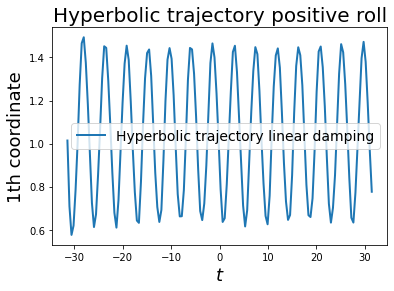

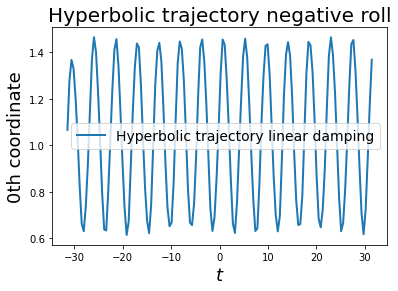

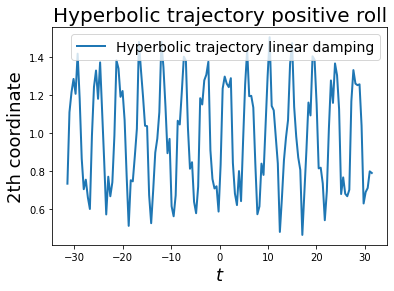

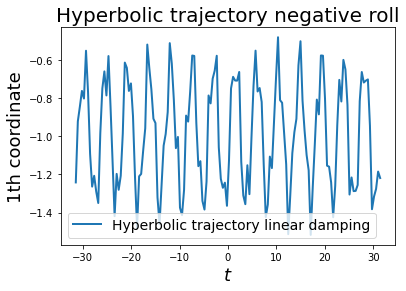

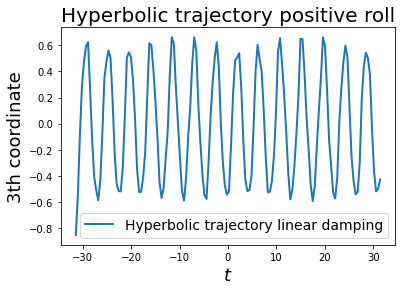

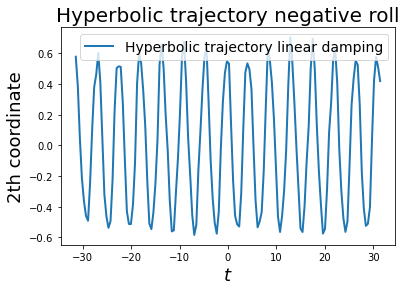

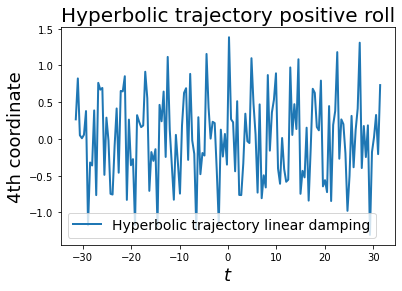

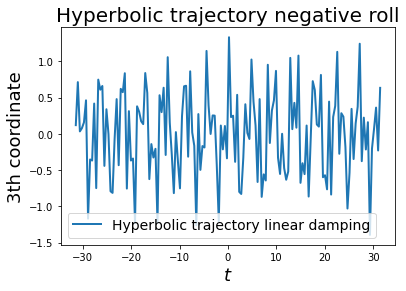

In [23]:
fig = plt.figure()
for i in range(0, 4):
    plt.plot(thyperbolic,Xhyperbolicplus[:,i],linewidth = 2,label = "Hyperbolic trajectory linear damping")  
    plt.title("Hyperbolic trajectory positive roll", fontsize=20)
    plt.xlabel("$t$", fontsize=18)
    plt.ylabel(str(i+1) + "th coordinate", fontsize=18)
    plt.legend(fontsize=14)
    plt.show()
    plt.plot(thyperbolic,Xhyperbolicminus[:,i]  ,linewidth = 2,label = "Hyperbolic trajectory linear damping")  
    plt.title("Hyperbolic trajectory negative roll", fontsize=20)
    plt.xlabel("$t$", fontsize=18)
    plt.ylabel(str(i) + "th coordinate", fontsize=18)
    plt.legend(fontsize=14)
    plt.show()